# PENGOLAHAN DATA SKRIPSI

In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set folder kerja ke dalam Google Drive
folder_path = "/content/drive/My Drive/skripsi_"
os.chdir(folder_path)

# Cek direktori aktif
print("Folder kerja saat ini:", os.getcwd())

Mounted at /content/drive
Folder kerja saat ini: /content/drive/My Drive/skripsi_


# Dapatkan Data Citra

In [ ]:
import ee

ee.Authenticate()

ee.Initialize(project='ee-222112076')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10

  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [ ]:
ee.data.listAssets('projects/ee-222112076/assets')

In [ ]:
import geemap.core as geemap

roi_asset = 'projects/ee-222112076/assets/_batas_desa_semarang_21' # Replace with your asset ID
roi = ee.FeatureCollection(roi_asset)

dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(roi)
    .filterDate('2021-01-01', '2021-12-30')
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    # .sort("CLOUD_COVERAGE_ASSESSMENT")
    # .first()
    .map(mask_s2_clouds)
)

rstr = dataset.median()

visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

m = geemap.Map()
m.set_center(110.41019874390831,-6.98297691064878, 15)
m.add_layer(rstr, visualization, 'RGB')
m

In [ ]:
# Define the export task
export_task = ee.batch.Export.image.toDrive(
    image=rstr,
    folder='citra_semarang',
    description='Sentinel2_2021_BPS',
    scale=10,
    region=roi.geometry(),
)

# Start the task
export_task.start()

print("Export task started. Check your Google Drive for the GeoTIFF file.")

# Zonal Statistic Citra

In [ ]:
!pip install rasterio

In [ ]:
!pip install rasterstats

## Batas Administrasi Desa Kota Semarang

In [ ]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import pandas as pd
import uuid
import random
import string


gdb_path = "/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/wilayah_rt_kumuh.gpkg"

# Load the vector data (polygons)
gdf = gpd.read_file(gdb_path, layer='rt_kumuh')
# Convert to a projected CRS For Semarang (WGS 84/UTM ZOne 49S)
utm_crs = "EPSG:32749"
gdf = gdf.to_crs(utm_crs)

gdf.columns
gdf = gdf.rename(columns={'_NILAI': 'skor_kumuh'})
# gdf = gdf.rename(columns={'kumuh_semarang_skor_kumuh': 'skor_kumuh'})

# Convert 'skor_kumuh' column to numeric, coercing errors to NaN
gdf['skor_kumuh'] = pd.to_numeric(gdf['skor_kumuh'], errors='coerce')

gdf['kode_kumuh'] =  pd.factorize(gdf['_TINGKAT'])[0]
# gdf['kode_kumuh'] =  pd.factorize(gdf['kumuh_semarang_status_kumuh'])[0]

def generate_id():
  letters = string.ascii_lowercase
  return ''.join(random.choice(letters + string.digits) for i in range(10))

# Assuming 'gdf' is your GeoDataFrame
gdf['id'] = [generate_id() for _ in range(len(gdf))]
gdf = gdf.set_index('id')

# If you want to move the index to the first column:
gdf = gdf.reset_index()

if 'perimeter' in gdf.columns:
    gdf = gdf.drop('perimeter', axis=1)


# INDEX Zonal Statistik

## NDBI

In [ ]:
# Paths to your files
tif_path = "/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/citra_index/ndbi.tif"

# Compute zonal statistics (mean)
stats = zonal_stats(gdf, tif_path, stats=["mean"], nodata=-9999)

# Add results to GeoDataFrame
gdf["ndbi_mean"] = [s["mean"] for s in stats]

## UI

In [ ]:
# Paths to your files
tif_path = "/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/citra_index/ui.tif"

# Compute zonal statistics (mean)
stats = zonal_stats(gdf, tif_path, stats=["mean"], nodata=-9999)

# Add results to GeoDataFrame
gdf["ui_mean"] = [s["mean"] for s in stats]

## BUI

In [ ]:
tif_path = "/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/citra_index/bui.tif"

# Compute zonal statistics (mean)
stats = zonal_stats(gdf, tif_path, stats=["mean"], nodata=-9999)

# Add results to GeoDataFrame
gdf["bui_mean"] = [s["mean"] for s in stats]

## NDVI

In [ ]:
tif_path = "/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/citra_index/ndvi.tif"

# Compute zonal statistics (mean)
stats = zonal_stats(gdf, tif_path, stats=["mean"], nodata=-9999)

# Add results to GeoDataFrame
gdf["ndvi_mean"] = [s["mean"] for s in stats]

## LSWI

In [ ]:
tif_path = "/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/citra_index/lswi.tif"

# Compute zonal statistics (mean)
stats = zonal_stats(gdf, tif_path, stats=["mean"], nodata=-9999)

# Add results to GeoDataFrame
gdf["lswi_mean"] = [s["mean"] for s in stats]

## MLSWI

In [ ]:
tif_path = "/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/citra_index/mlswi.tif"

# Compute zonal statistics (mean)
stats = zonal_stats(gdf, tif_path, stats=["mean"], nodata=-9999)

# Add results to GeoDataFrame
gdf["mlswi_mean"] = [s["mean"] for s in stats]

## MNDWI

In [ ]:
tif_path = "/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/citra_index/mndwi.tif"

# Compute zonal statistics (mean)
stats = zonal_stats(gdf, tif_path, stats=["mean"], nodata=-9999)

# Add results to GeoDataFrame
gdf["mndwi_mean"] = [s["mean"] for s in stats]

## Random Skor Kumuh

In [ ]:
import numpy as np
import random

# Set a seed for reproducibility
np.random.seed(42)
gdf.loc[gdf['skor_kumuh'] == 0, 'skor_kumuh'] = np.random.randint(8, 15, size=len(gdf[gdf['skor_kumuh'] == 0]))

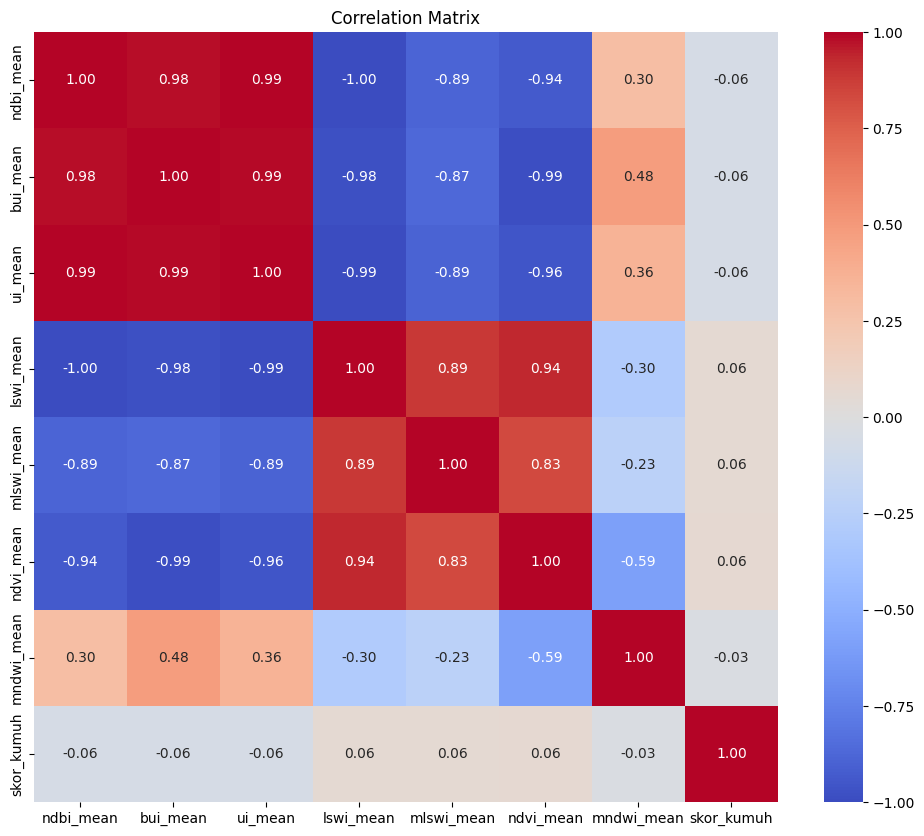

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = gdf[["ndbi_mean",'bui_mean', 'ui_mean',"lswi_mean", "mlswi_mean", "ndvi_mean",'mndwi_mean','skor_kumuh']].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# OSM Data

## Road Distance

In [ ]:
import pandas as pd
from shapely.ops import nearest_points
from geopy.distance import geodesic

# Load point and line GeoDataFrames (assuming they are in EPSG:4326)
gdf["centroid"] = gdf.geometry.centroid
gdf['centroid'] = gdf.centroid
point_gdf = gdf['centroid'] # Your point vector file
line_gdf = gpd.read_file("/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/poi/jalan.gpkg")
line_gdf = line_gdf.to_crs(utm_crs)

# Calculate distances for each point individually
distances = []
# Compute the minimum Euclidean distance from each point to the nearest line
distances = point_gdf.geometry.apply(lambda point: line_gdf.distance(point).min())

# Add the distance column to the point GeoDataFrame
gdf["distance_road"] = distances #Adding the distance to the original GeoDataFrame
gdf['distance_road']

,distance_road
0,14.018415
1,38.938793
2,0.192961
3,13.246488
4,19.798376
...,...
10412,18.337056
10413,3.369660
10414,11.602386
10415,12.004827


## Road Density

In [ ]:
import geopandas as gpd

# Load data
road_gdf = gpd.read_file("/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/poi/jalan.gpkg")
road_gdf = road_gdf.to_crs(utm_crs)

jalan_clipped = gpd.overlay(road_gdf, gdf[["id", "geometry"]], how="intersection")


# Calculate length of each clipped road segment in kilometers
jalan_clipped["length"] = jalan_clipped.geometry.length

# Sum total road length per kelurahan
road_length_per_kel = jalan_clipped.groupby("id")["length"].sum().reset_index()
# Merge total road length into kelurahan layer
gdf_merge = gdf.merge(road_length_per_kel, on="id", how="left")

gdf_merge["length"] = gdf_merge["length"].fillna(0)
gdf['length'] = gdf_merge['length']

gdf["area"] = gdf.geometry.area

gdf["road_density"] = gdf["length"] / gdf["area"]

# # Replace NaNs (e.g., no road in area) with 0
gdf["road_density"] = gdf["road_density"].fillna(0)

gdf["road_density"]

,road_density
0,0.026609
1,0.025582
2,0.038867
3,0.026670
4,0.021216
...,...
10412,0.035471
10413,0.041161
10414,0.020828
10415,0.020522


## WTP Distance

In [ ]:
# Load two point datasets
point_gdf1 = gdf['centroid']  # First set of points
point_gdf2 = gpd.read_file("/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/poi/pdam.gpkg")

point_gdf2 = point_gdf2.to_crs(utm_crs)

# Compute the minimum distance from each point in gdf1 to all points in gdf2
distance = point_gdf1.geometry.apply(lambda p: point_gdf2.distance(p).min())

# Add distance column
gdf["wtp_distance"] = distance
gdf['wtp_distance']


,wtp_distance
0,1832.533303
1,1916.055898
2,2542.878257
3,2235.742654
4,2042.759756
...,...
10412,1684.941586
10413,1219.937477
10414,1789.860947
10415,1548.592290


## River Dinstance

In [ ]:
import pandas as pd
from shapely.ops import nearest_points
from geopy.distance import geodesic

# Load point and line GeoDataFrames
point_gdf = gdf['centroid']

line_gdf = gpd.read_file("/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/poi/sungai.gpkg")
line_gdf = line_gdf.to_crs(utm_crs)
# print(line_gdf)

# Calculate distances for each point individually
distances = []
# Compute the minimum Euclidean distance from each point to the nearest line
distances = point_gdf.geometry.apply(lambda point: line_gdf.distance(point).min())

# Add distance column to the point GeoDataFrame
gdf["distance_river"] = distances
gdf['distance_river']

,distance_river
0,794.130464
1,681.613884
2,56.772727
3,464.332603
4,644.293140
...,...
10412,344.517299
10413,178.450770
10414,714.987552
10415,1056.440014


## Recycling Point Distance

In [ ]:
# Load two point datasets
point_gdf1 = gdf['centroid']  # First set of points
point_gdf2 = gpd.read_file("/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/poi/tps.gpkg")  # Second set of points

point_gdf2 = point_gdf2.to_crs(utm_crs)

# Compute the minimum distance from each point in gdf1 to all points in gdf2
distance = point_gdf1.geometry.apply(lambda p: point_gdf2.distance(p).min())

# Add distance column
gdf["distance_tps"] = distance
gdf['distance_tps']


,distance_tps
0,4725.685247
1,4816.658640
2,5470.938395
3,4860.092441
4,4636.206606
...,...
10412,2785.121531
10413,2320.524127
10414,4926.088099
10415,4619.126778


## FireStation Distance

In [ ]:
# Load two point datasets
point_gdf1 = gdf['centroid']  # First set of points
point_gdf2 = gpd.read_file("/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/poi/pemadam.gpkg")  # Second set of points

point_gdf2 = point_gdf2.to_crs(utm_crs)

# Compute the minimum distance from each point in gdf1 to all points in gdf2
distance = point_gdf1.geometry.apply(lambda p: point_gdf2.distance(p).min())

# Add distance column
gdf["dist_pemadam"] = distance
gdf['dist_pemadam']


,dist_pemadam
0,433.096251
1,424.764019
2,910.169928
3,300.091045
4,187.805427
...,...
10412,5001.433922
10413,4740.513400
10414,617.337337
10415,665.898762


## Hydrant Distance

In [ ]:
import numpy as np
from scipy.spatial import cKDTree

# Load two point datasets
point_gdf1 = gdf['centroid']
point_gdf2 = gpd.read_file("/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/poi/hydrant.gpkg")

point_gdf2 = point_gdf2.to_crs(utm_crs)

# Compute the minimum distance from each point in gdf1 to all points in gdf2
distance = point_gdf1.geometry.apply(lambda p: point_gdf2.distance(p).min())

# Add distance column
gdf["distance_hydrant"] = distance # Adding the distance to the original GeoDataFrame
gdf['distance_hydrant']

,distance_hydrant
0,1553.954271
1,1559.006380
2,1808.423228
3,1355.909607
4,1317.204273
...,...
10412,1693.046028
10413,1566.305944
10414,1750.983969
10415,1719.024786


## Save Data Awal

In [ ]:
# Drop the 'centroid' column as it is not needed for saving to GeoPackage
if 'centroid' in gdf.columns:
    gdf = gdf.drop(columns=['centroid'])

# Add the .gpkg extension to the filename
output_path = '/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/raw_data_2021.gpkg'
gdf.to_file(output_path, driver="GPKG")

print(f"GeoDataFrame saved to: {output_path}")

GeoDataFrame saved to: /content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/raw_data_2021.gpkg


# Transfomasi dan Correlation

In [ ]:
import geopandas as gpd

gdf = gpd.read_file('/content/drive/MyDrive/skripsi_/Slum/olahan/Semarang/2021/raw_data_2021.gpkg')

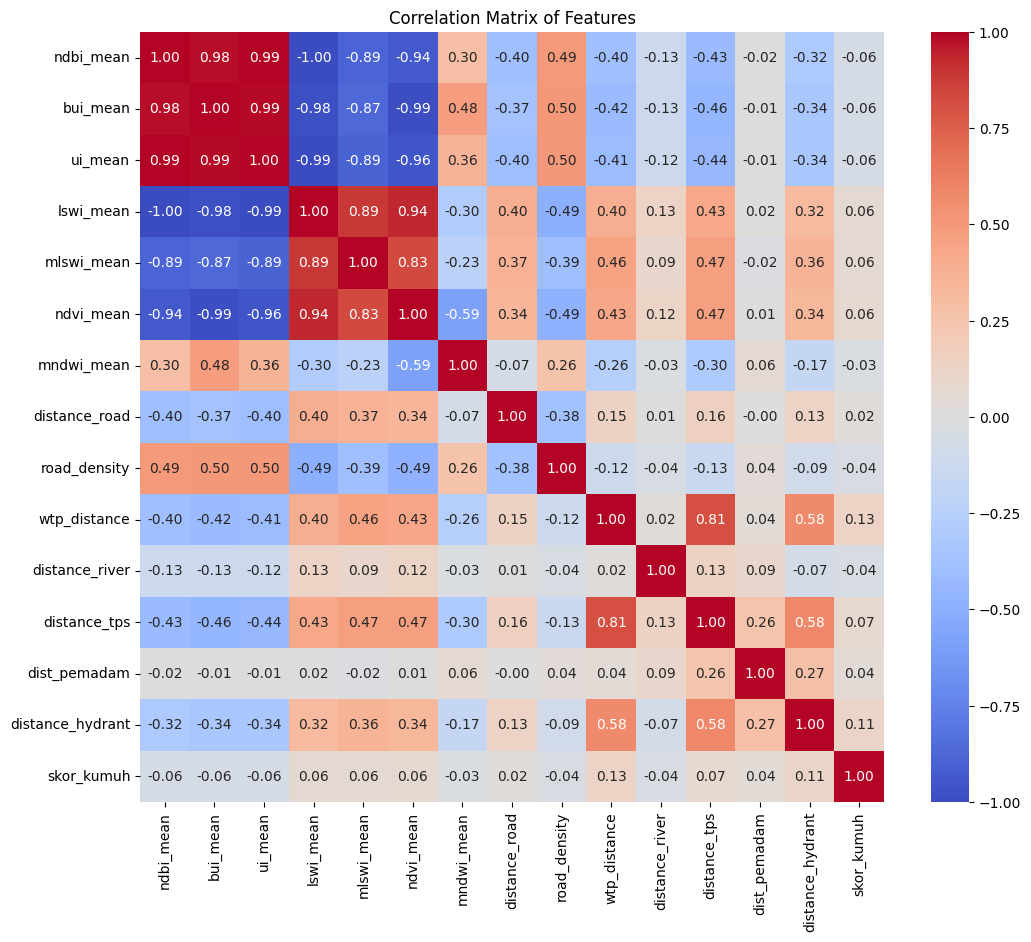

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


cor = gdf[["ndbi_mean",'bui_mean', 'ui_mean',"lswi_mean", "mlswi_mean", "ndvi_mean",'mndwi_mean','distance_road',  'road_density','wtp_distance','distance_river','distance_tps' , 'dist_pemadam','distance_hydrant','skor_kumuh']].corr(method = 'pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

for col in ["ndbi_mean",'bui_mean', 'ui_mean',"lswi_mean", "mlswi_mean", "ndvi_mean",'mndwi_mean','distance_road',  'road_density','wtp_distance','distance_river','distance_tps' , 'dist_pemadam','distance_hydrant']:
    correlation, p_value = pearsonr(gdf[col], gdf['skor_kumuh'])

    if p_value < 0.05:
      continue
    else:
      print(f"Correlation between {col} and skor_kumuh: {correlation:.2f}, p-value: {p_value:.3f}")
      print(f"The correlation between {col} and skor_kumuh is not statistically significant.\n")


In [ ]:
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

pt = PowerTransformer(method='yeo-johnson')

column_transformed = ['ndbi_mean','bui_mean', 'ui_mean',"lswi_mean", "mlswi_mean", "ndvi_mean",'mndwi_mean', 'distance_road',  'road_density','wtp_distance','distance_river','distance_tps' , 'dist_pemadam','distance_hydrant']

idx = gdf[column_transformed]

transformed_data = pt.fit_transform(idx)

transformed_df = pd.DataFrame(transformed_data, columns = column_transformed , index=gdf.index)

gdf[column_transformed] = transformed_df[column_transformed]


In [ ]:
# Add the .gpkg extension to the filename
output_path = '/content/drive/MyDrive/skripsi_/dataset_2021.gpkg'
gdf.to_file(output_path, driver="GPKG")

print(f"Transformed GeoDataFrame saved to: {output_path}")

Transformed GeoDataFrame saved to: /content/drive/MyDrive/skripsi_/dataset_2021.gpkg


# Pembangunan Model

## Spliting Data

In [3]:
import geopandas as gpd
gdf = gpd.read_file('/content/drive/MyDrive/skripsi_/dataset_2021.gpkg')

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Features (X) and target variable (y)
X = gdf[["ndbi_mean",'bui_mean', 'ui_mean',"lswi_mean", "mlswi_mean", "ndvi_mean",'mndwi_mean','distance_road', 'road_density','wtp_distance','distance_river','distance_tps' , 'dist_pemadam','distance_hydrant']]
y = gdf['kode_kumuh']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)  # Adjust test_size as needed

In [5]:
print("Before SMOTE")
print(y_train.value_counts())
print(y_test.value_counts())

Before SMOTE
kode_kumuh
0    8044
1     262
2      27
Name: count, dtype: int64
kode_kumuh
0    2012
1      65
2       7
Name: count, dtype: int64


## Under Sampling

In [6]:
from imblearn.under_sampling import ClusterCentroids

undersampler = ClusterCentroids(sampling_strategy={0: 5000}, random_state=42)
X_temp, y_temp = undersampler.fit_resample(X, y)

## SMOTE Sampling

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(
    sampling_strategy={1: 600, 2:200},
    random_state=42
)

X_resampled, y_resampled = smote.fit_resample(X_temp, y_temp)

print("Before SMOTE")
print(y_train.value_counts())

print("\nAfter SMOTE")
print(y_resampled.value_counts())

Before SMOTE
kode_kumuh
0    8044
1     262
2      27
Name: count, dtype: int64

After SMOTE
kode_kumuh
0    5000
1     600
2     200
Name: count, dtype: int64


## Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Define the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'], # perhitungan loss untuk menentukan node
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Perform GridSearchCV
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Best parameters found
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Best hyperparameters from tuning
best_params = {
    'criterion': 'entropy',
    'max_depth': 7,
    'min_samples_leaf': 2,
    'min_samples_split': 10,
}

# Initialize the model with best hyperparameters
dt = DecisionTreeClassifier(**best_params, random_state=42)

# Train the model
dt.fit(X_resampled, y_resampled)

# Predict on test set
y_pred = dt.predict(X_test)

# Evaluation
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nF1-score:", f1_score(y_test, y_pred, average='macro'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))



Confusion Matrix:
[[1935   61   16]
 [  25   33    7]
 [   0    0    7]]

F1-score: 0.589264319897621

Classification Report:
              precision    recall  f1-score   support

           0      0.987     0.962     0.974      2012
           1      0.351     0.508     0.415        65
           2      0.233     1.000     0.378         7

    accuracy                          0.948      2084
   macro avg      0.524     0.823     0.589      2084
weighted avg      0.965     0.948     0.955      2084



In [ ]:
from sklearn.model_selection import cross_val_score

accuracy = cross_val_score(dt, X_resampled, y_resampled, cv=5, scoring='accuracy')
precision = cross_val_score(dt, X_resampled, y_resampled, cv=5, scoring='precision_macro')
recall = cross_val_score(dt, X_resampled, y_resampled, cv=5, scoring='recall_macro')
f1 = cross_val_score(dt, X_resampled, y_resampled, cv=5, scoring='f1_macro')

print("HASIL Pada Cross Validation Decision Tree")
print("Accuracy:", round(accuracy.mean(),3))
print("Precision:", round(precision.mean(),3))
print("Recall:", round(recall.mean(),3))
print("Mean F1-score:", round(f1.mean(),3))


HASIL Pada Cross Validation Decision Tree
Accuracy: 0.898
Precision: 0.728
Recall: 0.691
Mean F1-score: 0.697


## Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Initialize base model
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use RandomizedSearchCV for tuning
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    verbose=1,
    n_jobs=-1  # Use all available CPUs
)

# Fit the model
grid_search.fit(X_resampled, y_resampled)

# Print best parameters
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Define the best parameters from tuning
best_params = {
    'n_estimators': 200,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': 10,
    'random_state': 42,
}

# Train the model using the best parameters
rf_best = RandomForestClassifier(**best_params, class_weight='balanced')

rf_best.fit(X_resampled, y_resampled)

# Make predictions
y_pred = rf_best.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nF1-score:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))


Confusion Matrix:
 [[1938   63   11]
 [   0   63    2]
 [   0    0    7]]

F1-score: 0.7198234017258914

Classification Report:
               precision    recall  f1-score   support

           0      1.000     0.963     0.981      2012
           1      0.500     0.969     0.660        65
           2      0.350     1.000     0.519         7

    accuracy                          0.964      2084
   macro avg      0.617     0.977     0.720      2084
weighted avg      0.982     0.964     0.970      2084



In [ ]:
from sklearn.model_selection import cross_val_score

accuracy = cross_val_score(rf_best, X_resampled, y_resampled, cv=5, scoring='accuracy')
precision = cross_val_score(rf_best, X_resampled, y_resampled, cv=5, scoring='precision_macro')
recall = cross_val_score(rf_best, X_resampled, y_resampled, cv=5, scoring='recall_macro')
f1 = cross_val_score(rf_best, X_resampled, y_resampled, cv=5, scoring='f1_macro')

print("HASIL Pada Cross Validation Random Forest :")
print("Accuracy:", round(accuracy.mean(),3))
print("Precision:", round(precision.mean(),3))
print("Recall:", round(recall.mean(),3))
print("Mean F1-score:", round(f1.mean(),3))


HASIL Pada Cross Validation Random Forest :
Accuracy: 0.921
Precision: 0.797
Recall: 0.811
Mean F1-score: 0.799


## XGBoost Model

In [ ]:
!pip install xgboost

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Initialize base model - changed for binary classification
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # Objective for multi-class classification
    num_class=3,                 # Number of classes
    eval_metric='mlogloss',      # Evaluation metric for multi-class
    random_state=42,
)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],           # Reduce from 500
    'learning_rate': [0.01, 0.05, 0.1],      # Lower learning rates
    'max_depth': [3, 4, 5],                  # Reduce from 7
    'min_child_weight': [3, 5, 7],           # Increase from 1
    'gamma': [0.1, 0.2],                # Increase regularization
    'subsample': [0.6, 0.8],            # Reduce from 1.0
    'colsample_bytree': [0.6,  0.8],     # Reduce from 1.0
    'reg_alpha': [0.5, 1.0],            # L1 regularization
    'reg_lambda': [1.0, 2.0]            # L2 regularization

}


# Use RandomizedSearchCV for tuning
random_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1  # Use all available CPUs
)

# Fit the model
random_search.fit(X_resampled, y_resampled)

# Print best parameters
print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.6}


In [11]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Define the best parameters from tuning
best_params = {
    'subsample': 0.6,
    'n_estimators': 300,
    'min_child_weight': 3,
    'max_depth': 5,
    'learning_rate': 0.1,
    'gamma': 0.1,
    'colsample_bytree': 0.8,
    'objective': 'multi:softprob',
    'num_class' : 3,
    'reg_lambda': 1.0,
    'reg_alpha': 0.5,
    'eval_metric': 'mlogloss',  # Multi-class log loss
    'random_state': 63  # Ensure reproducibility

}

# Train the model using the best parameters
xgb_best = xgb.XGBClassifier(**best_params)
# Wrap with calibration

xgb_best.fit(X_resampled, y_resampled)

# Make predictions
y_pred = xgb_best.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nF1-score:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))


Confusion Matrix:
 [[2001    8    3]
 [   1   64    0]
 [   0    0    7]]

F1-score: 0.9182821481619827

Classification Report:
               precision    recall  f1-score   support

           0      1.000     0.995     0.997      2012
           1      0.889     0.985     0.934        65
           2      0.700     1.000     0.824         7

    accuracy                          0.994      2084
   macro avg      0.863     0.993     0.918      2084
weighted avg      0.995     0.994     0.994      2084



In [ ]:
from sklearn.model_selection import cross_val_score

accuracy = cross_val_score(xgb_best, X_resampled, y_resampled, cv=5, scoring='accuracy')
precision = cross_val_score(xgb_best, X_resampled, y_resampled, cv=5, scoring='precision_macro')
recall = cross_val_score(xgb_best, X_resampled, y_resampled, cv=5, scoring='recall_macro')
f1 = cross_val_score(xgb_best, X_resampled, y_resampled, cv=5, scoring='f1_macro')

print("HASIL XGB Pada Cross Validation ")
print("Accuracy:", round(accuracy.mean(),3))
print("Precision:", round(precision.mean(),3))
print("Recall:", round(recall.mean(),3))
print("Mean F1-score:", round(f1.mean(),3))

HASIL XGB Pada Cross Validation 
Accuracy: 0.937
Precision: 0.889
Recall: 0.794
Mean F1-score: 0.831


# Evaluasi Model

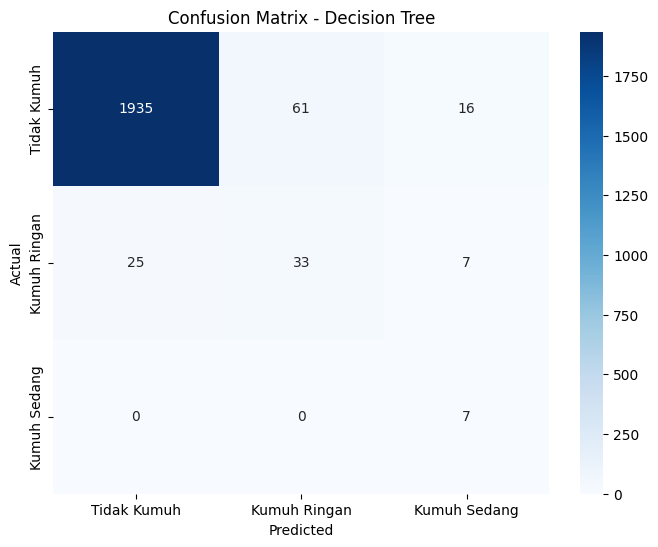

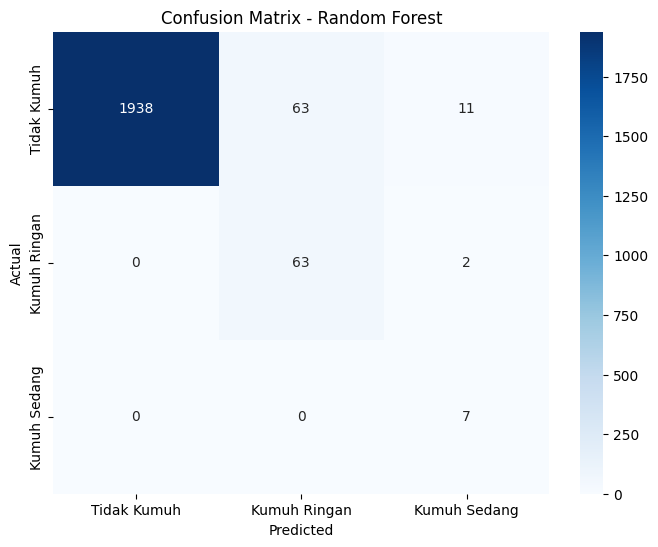

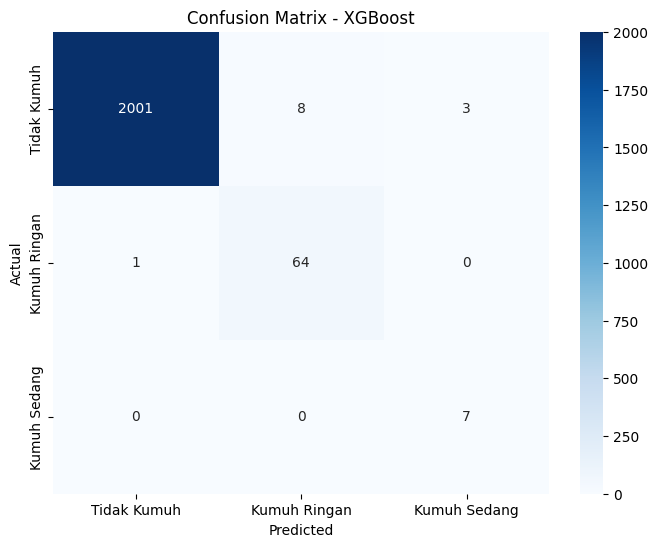

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(y_test, dt.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tidak Kumuh', 'Kumuh Ringan', 'Kumuh Sedang'],
            yticklabels=['Tidak Kumuh', 'Kumuh Ringan', 'Kumuh Sedang'])
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, rf_best.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tidak Kumuh', 'Kumuh Ringan', 'Kumuh Sedang'],
            yticklabels=['Tidak Kumuh', 'Kumuh Ringan', 'Kumuh Sedang'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, xgb_best.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tidak Kumuh', 'Kumuh Ringan', 'Kumuh Sedang'],
            yticklabels=['Tidak Kumuh', 'Kumuh Ringan', 'Kumuh Sedang'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Selection

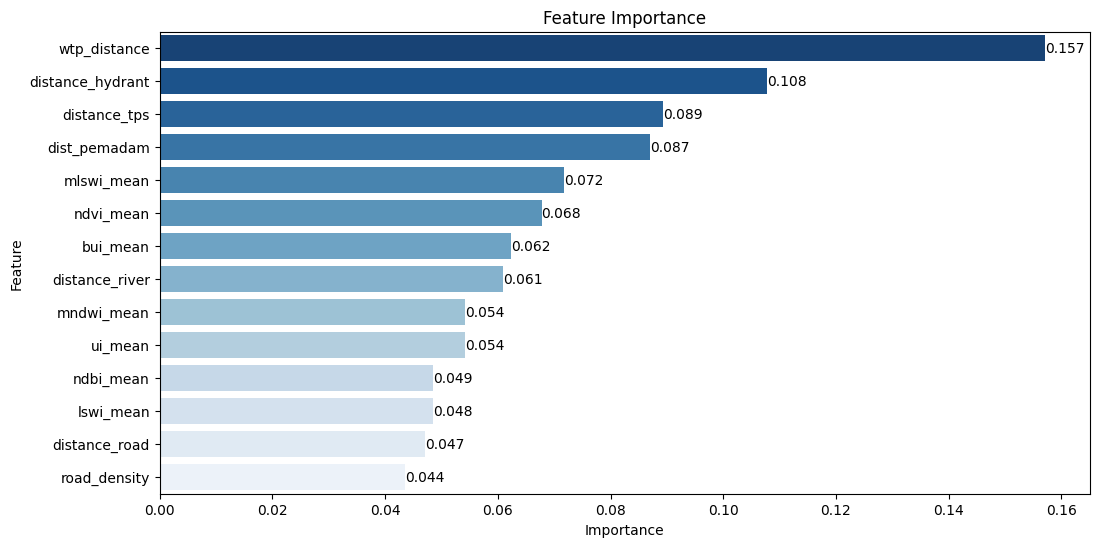

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
# Get feature importance
feature_importances = xgb_best.feature_importances_

feature_names = X_resampled.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', palette='Blues_r', legend=False)

# Add labels to the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center')

plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Shap Analisis (Tujuan 3)

In [ ]:
import shap
import numpy as np
explainer = shap.Explainer(xgb_best)

# Calculate SHAP values
shap_values = explainer(X_test)

In [ ]:
shap_agg_non = (shap_values[:, :, 1] + shap_values[:, :, 2])

shap_binary_diff = shap_agg_non - shap_values[:, :, 0]

shap_binary_diff.shape

(2084, 14)

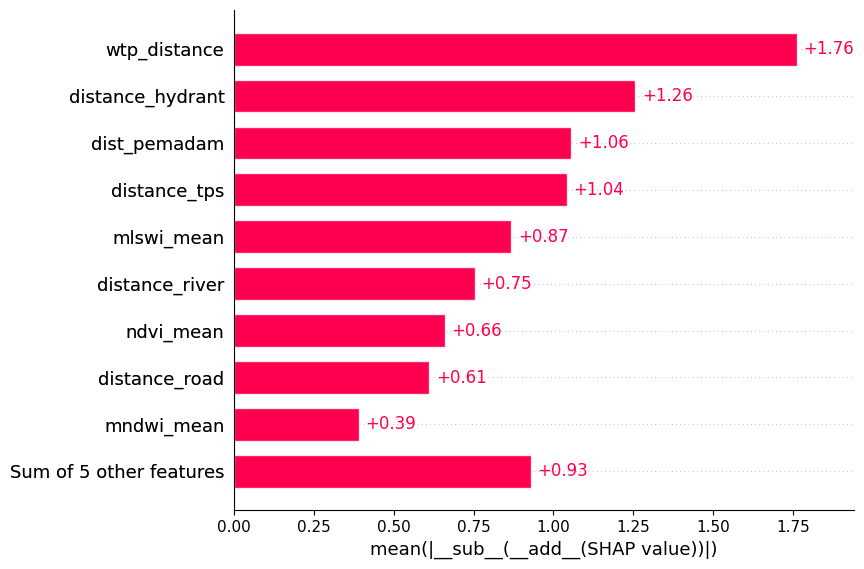

In [ ]:
shap.plots.bar(shap_binary_diff)

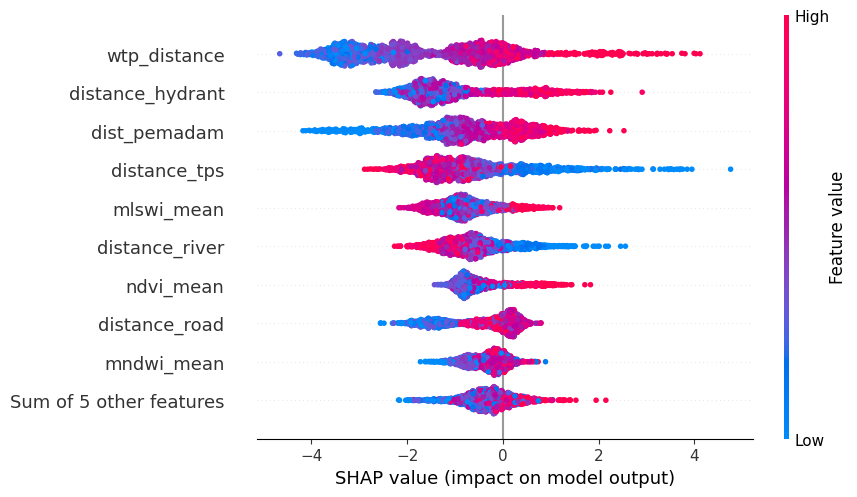

In [ ]:
shap.plots.beeswarm(shap_binary_diff)

# Hasil Klasifikasi

In [ ]:
gdf['dt_classified'] = dt.predict(gdf[["ndbi_mean",'bui_mean', 'ui_mean',"lswi_mean", "mlswi_mean", "ndvi_mean",'mndwi_mean','distance_road',  'road_density','wtp_distance','distance_river','distance_tps' , 'dist_pemadam','distance_hydrant']])
gdf['dt_classified'] = gdf['dt_classified'].map({0: "tidak kumuh", 1: "kumuh ringan", 2:"kumuh sedang"})

print(gdf['dt_classified'].head())

0    tidak kumuh
1    tidak kumuh
2    tidak kumuh
3    tidak kumuh
4    tidak kumuh
Name: dt_classified, dtype: object


In [ ]:
gdf['rf_best_classified'] = rf_best.predict(gdf[["ndbi_mean",'bui_mean', 'ui_mean',"lswi_mean", "mlswi_mean", "ndvi_mean",'mndwi_mean','distance_road',  'road_density','wtp_distance','distance_river','distance_tps' , 'dist_pemadam','distance_hydrant']])
gdf['rf_best_classified'] = gdf['rf_best_classified'].map({0: "tidak kumuh", 1: "kumuh ringan", 2:"kumuh sedang"})

print(gdf['rf_best_classified'].head())

0    tidak kumuh
1    tidak kumuh
2    tidak kumuh
3    tidak kumuh
4    tidak kumuh
Name: rf_best_classified, dtype: object


In [ ]:
gdf['xgb_best_classified'] = xgb_best.predict(gdf[["ndbi_mean",'bui_mean', 'ui_mean',"lswi_mean", "mlswi_mean", "ndvi_mean",'mndwi_mean','distance_road',  'road_density','wtp_distance','distance_river','distance_tps' , 'dist_pemadam','distance_hydrant']])
gdf['xgb_best_classified'] = gdf['xgb_best_classified'].map({0: "tidak kumuh", 1: "kumuh ringan", 2:"kumuh sedang"})

print(gdf['xgb_best_classified'].head())

0    tidak kumuh
1    tidak kumuh
2    tidak kumuh
3    tidak kumuh
4    tidak kumuh
Name: xgb_best_classified, dtype: object


In [ ]:
gdf.to_file("hasil_pred_rt.gpkg", driver="GPKG")

## Cek Similarity

In [ ]:
import geopandas as gpd
gdb_path = "/content/drive/MyDrive/skripsi_/hasil_pred_rt.gpkg"

# Load the vector data (polygons)
gdf = gpd.read_file(gdb_path)

In [ ]:
gdf.columns

Index(['id', 'IDRT', 'KABKOTNO', 'KECNO', 'KABKOTA', 'KECAMATAN', 'RT_RW',
       'DESANO', 'PROVNO', 'DESA', 'PROVINSI', 'TAHUN', 'skor_kumuh',
       '_TINGKAT', 'kode_kumuh', 'ndbi_mean', 'ui_mean', 'bui_mean',
       'ndvi_mean', 'lswi_mean', 'mlswi_mean', 'mndwi_mean', 'distance_road',
       'length', 'area', 'road_density', 'wtp_distance', 'distance_river',
       'distance_tps', 'dist_pemadam', 'distance_hydrant', 'dt_classified',
       'rf_best_classified', 'xgb_best_classified', 'geometry'],
      dtype='object')

In [ ]:
gdf_filtered = gdf[gdf['kode_kumuh'] != 0].copy()

In [ ]:
from sklearn.metrics import accuracy_score

# and it contains the true labels, while 'dt_classified' is the predicted labels
accuracy = accuracy_score(gdf_filtered['_status_kumuh'], gdf_filtered['dt_classified'])
print(f"Accuracy of dt_classified vs. _status_kumuh: {accuracy}")

# You can similarly compare with other classification results (rf_best_classified, xgb_best_classified)
accuracy_rf = accuracy_score(gdf_filtered['_status_kumuh'], gdf_filtered['rf_best_classified'])
print(f"Accuracy of rf_best_classified vs. _status_kumuh: {accuracy_rf}")

accuracy_xgb = accuracy_score(gdf_filtered['_status_kumuh'], gdf_filtered['xgb_best_classified'])
print(f"Accuracy of xgb_best_classified vs. _status_kumuh: {accuracy_xgb}")


Accuracy of dt_classified vs. _status_kumuh: 0.6149584487534626
Accuracy of rf_best_classified vs. _status_kumuh: 0.9778393351800554
Accuracy of xgb_best_classified vs. _status_kumuh: 0.9750692520775623


In [ ]:
gdf['_status_kumuh'] = gdf['kode_kumuh'].map({0: "tidak kumuh", 1: "kumuh ringan", 2:"kumuh sedang"})

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("--- Decision Tree Classification Report ---")
print(classification_report(gdf['_status_kumuh'], gdf['dt_classified'], digits=3))

print("--- Random Forest Classification Report ---")
print(classification_report(gdf['_status_kumuh'], gdf['rf_best_classified'], digits=3))

print("--- XGBoost Classification Report ---")
print(classification_report(gdf['_status_kumuh'], gdf['xgb_best_classified'], digits=3))

--- Decision Tree Classification Report ---
              precision    recall  f1-score   support

kumuh ringan      0.415     0.575     0.482       327
kumuh sedang      0.239     0.794     0.367        34
 tidak kumuh      0.988     0.967     0.977     10056

    accuracy                          0.954     10417
   macro avg      0.547     0.779     0.609     10417
weighted avg      0.967     0.954     0.960     10417

--- Random Forest Classification Report ---
              precision    recall  f1-score   support

kumuh ringan      0.483     0.969     0.645       327
kumuh sedang      0.391     1.000     0.562        34
 tidak kumuh      1.000     0.962     0.980     10056

    accuracy                          0.962     10417
   macro avg      0.625     0.977     0.729     10417
weighted avg      0.981     0.962     0.968     10417

--- XGBoost Classification Report ---
              precision    recall  f1-score   support

kumuh ringan      0.853     0.979     0.912       327
kum

In [ ]:
gdf.to_file("hasil_pred_rt.gpkg", driver="GPKG")

# Prediksi Seluruh Tahun

In [ ]:
gdf_ = gpd.read_file("merged_data.gpkg")

In [ ]:
from sklearn.preprocessing import PowerTransformer

# Select the columns to transform from gdf_
gdf_to_transform = gdf_[column_transformed]

# Apply the Yeo-Johnson transformation using the fitted transformer
transformed_gdf_data = pt.transform(gdf_to_transform)

# Create a new DataFrame with the transformed data and the same index and columns
transformed_gdf_df = pd.DataFrame(transformed_gdf_data, columns=column_transformed, index=gdf_.index)

# Update the gdf_ GeoDataFrame with the transformed columns
gdf_[column_transformed] = transformed_gdf_df[column_transformed]

print("Yeo-Johnson transformation applied to the relevant columns in gdf_.")

Yeo-Johnson transformation applied to the relevant columns in gdf_.


In [ ]:
gdf_['xgb_classified'] = xgb_best.predict(gdf_[["ndbi_mean", 'bui_mean', 'ui_mean',"lswi_mean", "mlswi_mean", "ndvi_mean",'mndwi_mean','distance_road', 'road_density','wtp_distance','distance_river','distance_tps' , 'dist_pemadam', 'distance_hydrant']])
gdf_['xgb_classfied_'] = gdf_['xgb_classified'].map({0: "tidak kumuh", 1: "kumuh ringan", 2:"kumuh sedang"})

print(gdf_['xgb_classfied_'].head())

0    tidak kumuh
1    tidak kumuh
2    tidak kumuh
3    tidak kumuh
4    tidak kumuh
Name: xgb_classfied_, dtype: object


In [ ]:
# Group by 'Tahun' and count the occurrences of each value in 'xgb_classfied_'
classification_counts_by_year = gdf_.groupby('Tahun')['xgb_classfied_'].value_counts().unstack(fill_value=0)

print(classification_counts_by_year)

xgb_classfied_  kumuh ringan  kumuh sedang  tidak kumuh
Tahun                                                  
2021                     375            45         9997
2022                     315            43        10059
2023                     342            30        10045
2024                     321            23        10073


In [ ]:
gdf_.to_file("hasil_.gpkg", driver="GPKG")